In [1]:
import math
import torch
import gpytorch
import cf_units
import datetime
import zarr
import dask

import dask.array as dsa
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')

pacific = sea_level_picontrol[dict(time=2000)].sel(xt_ocean=slice(-120,-115), yt_ocean=slice(-10,-5.1))

Text(0.5, 1.0, 'True Sea Level')

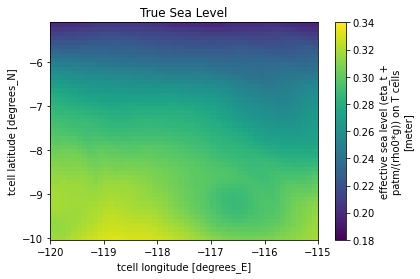

In [3]:
# Plot sea level of selected area
pacific['sea_level'].plot(vmin = 0.18, vmax = 0.34)
plt.title("True Sea Level")

Text(0.5, 1.0, 'Sea Level to Interpolate')

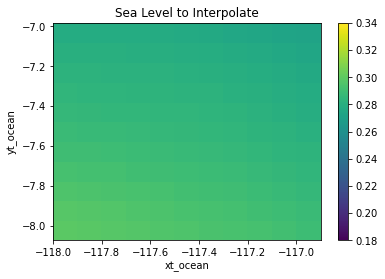

In [4]:
#Select chunk and remove from training data
sea_df = pacific['sea_level'].to_pandas()
test_chunk = sea_df.iloc[20:31, 20:31]
training = sea_df[~sea_df.isin(test_chunk)]

#Plot Chunk
xr.DataArray(test_chunk).plot(vmin = 0.18, vmax = 0.34)
plt.title("Sea Level to Interpolate")

Text(0.5, 1.0, 'Training Sea Level')

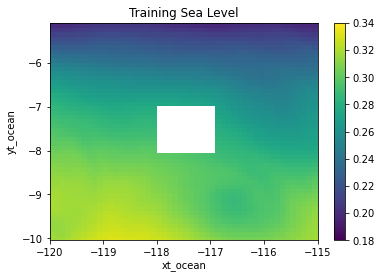

In [5]:
#Plot Training Data
xr.DataArray(training).plot(vmin = 0.18, vmax = 0.34)
plt.title("Training Sea Level")

In [6]:
# Formats sea level data to be compatible with tensor
def format_sea_level(data):
    formatted = []
    for i in range(len(data)):
        formatted.append(data[i])
    
    return torch.FloatTensor((np.array(formatted)).astype(float)).squeeze()

# Convert training and full data to stack format
# & Fill NaN's with Training mean
training = training.stack().reset_index()
testing = sea_df.stack().reset_index()

# Set training and testing y's
train_y = format_sea_level(np.array(training[0]))
test_y = format_sea_level(np.array(testing[0]))

In [7]:
# Set training and testing x's
train_x = torch.tensor(np.vstack((training['yt_ocean'], training['xt_ocean'])).T).squeeze()
test_x = torch.tensor(np.vstack((testing['yt_ocean'], testing['xt_ocean'])).T).squeeze()

In [8]:
#For plotting purposes only
plot_training = sea_df[~sea_df.isin(test_chunk)].fillna(-1).stack().reset_index()
plot_chunk = test_chunk.stack().reset_index()

plot_training_y = format_sea_level(np.array(plot_training[0]))
plot_chunk_y = format_sea_level(np.array(plot_chunk[0]))

plot_training_x = torch.tensor(np.vstack((plot_training['yt_ocean'], plot_training['xt_ocean'])).T).squeeze()
plot_chunk_x = torch.tensor(np.vstack((plot_chunk['yt_ocean'], plot_chunk['xt_ocean'])).T).squeeze()

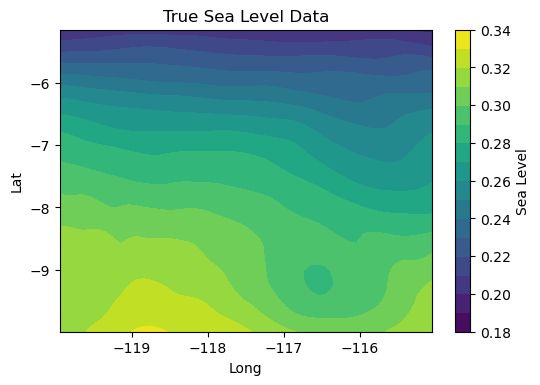

In [9]:
# Plot True Data
test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

levels = [0.18, 0.19, 0.2,0.21 ,0.22,0.23 ,0.24,0.25, 0.26,0.27 , 0.28,0.29 , 0.30,0.31, 0.32, 0.33, 0.34]

plt.figure(dpi=100)
plt.contourf(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape), levels)
plt.title("True Sea Level Data")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Sea Level')
plt.show()

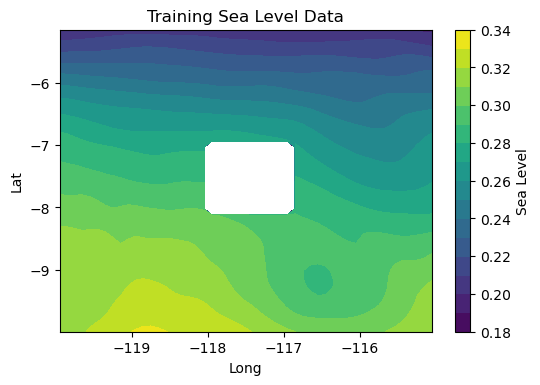

In [10]:
# Plot Training Data
plotting_X_1, plotting_X_2 = np.meshgrid(plot_training_x[:,1].unique(),plot_training_x[:,0].unique())

plt.figure(dpi=100)
plt.contourf(plotting_X_1, plotting_X_2,
             plot_training_y.reshape(plotting_X_2.shape), levels, vmin=0.18, vmax=0.34)
plt.title("Training Sea Level Data")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Sea Level')
plt.show()

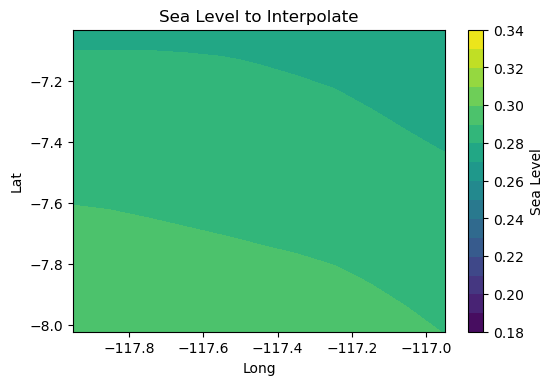

In [11]:
# Plot Interpolation Chunk
plotting_X_1, plotting_X_2 = np.meshgrid(plot_chunk_x[:,1].unique(),plot_chunk_x[:,0].unique())

plt.figure(dpi=100)
plt.contourf(plotting_X_1, plotting_X_2,
             plot_chunk_y.reshape(plotting_X_2.shape), levels, vmin=0.18, vmax=0.34)
plt.title("Sea Level to Interpolate")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Sea Level')
plt.show()

In [12]:
# Calculate mean std of x and y variables
ytrain_mean = train_y.mean()
ytrain_std = train_y.std()

ytest_mean = test_y.mean()
ytest_std = test_y.std()

# Normalize training data
train_y = ((train_y - train_y.mean()) / train_y.std())

# Normalize testing data
test_y = (test_y - test_y.mean()) / test_y.std()

In [13]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


hypers = {
    'covar_module.base_kernel.lengthscale': torch.tensor(1.7),
}

model.initialize(**hypers)

print(
    model.covar_module.base_kernel.lengthscale.item(),
)


1.6999999999999997


In [14]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
        
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()


/ext3/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


In [15]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

n=2500
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    train_pred = model(train_x).mean.detach()

pred_labels = observed_pred.mean.view(n)

# Calc abosolute error
delta_y = torch.abs(pred_labels - test_y).detach().numpy()

/ext3/miniconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [16]:
# Unnormalize Data
train_y = (train_y * ytrain_std) + ytrain_mean
test_y = (test_y * ytest_std) + ytest_mean
train_pred = (train_pred * ytrain_std) + ytrain_mean
pred_labels = (pred_labels * ytrain_std) + ytrain_mean

In [17]:
# Plot Training Data and Model Fit
# plotting_X_1, plotting_X_2 = np.meshgrid(plot_training_x[:,1].unique(),plot_training_x[:,0].unique())
# train_X_1, train_X_2 = np.meshgrid(test_x[:,1].unique(), train_x[:,0].unique())
# fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))

# ax[0].contourf(plotting_X_1, plotting_X_2,
#              plot_training_y.reshape(plotting_X_2.shape), levels, vmin=0.18, vmax=0.34)
# ax[0].set_title("Sea Level Training Unnormalized")
# ax[0].set_xlabel("Long")
# ax[0].set_ylabel("Lat")

# contour_ = ax[1].contourf(train_X_1, train_X_2,
#              train_pred.reshape(train_X_2.shape), levels, vmin=0.18, vmax=0.34)
# ax[1].set_title("RBF Fit Sea Level Model")
# ax[1].set_xlabel("Long")
# ax[1].set_ylabel("Lat")
# fig.colorbar(contour_)
# plt.show()

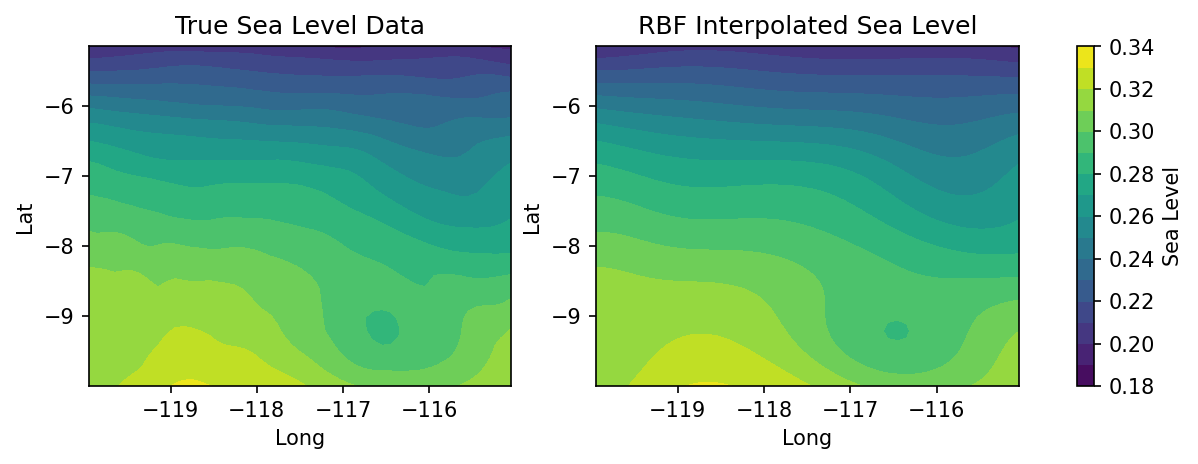

In [97]:
# Plot True Sea Level Data and GP Prediction
test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 3))

ax[0].contourf(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape), levels, vmin=0.18, vmax=0.34) 
ax[0].set_title("True Sea Level Data")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].contourf(test_X_1, test_X_2,
             pred_labels.detach().reshape(test_X_2.shape), levels, vmin=0.18, vmax=0.34)
ax[1].set_title("RBF Interpolated Sea Level")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")
cbar = fig.colorbar(contour_, ax=ax.ravel().tolist())
cbar.ax.set_ylabel('Sea Level')

plt.show()

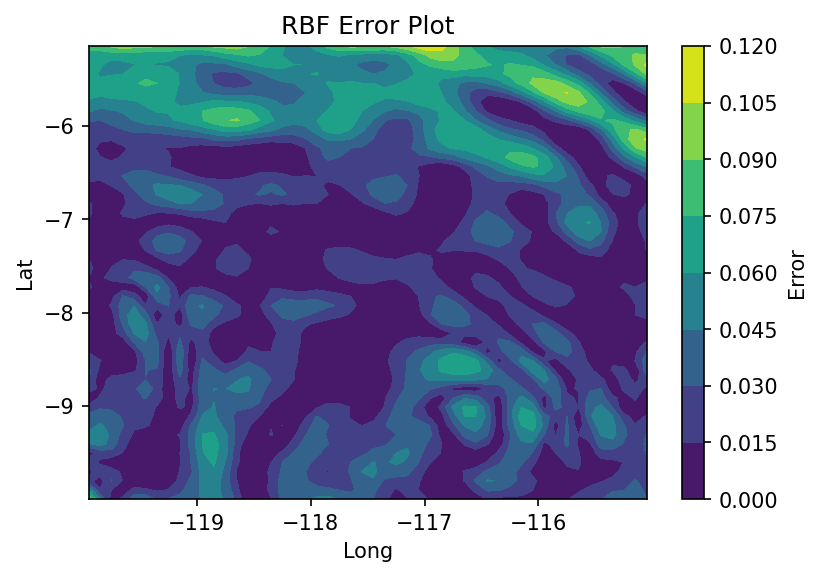

In [101]:
train_X_1, train_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

plt.figure(dpi=150)
plt.contourf(train_X_1, train_X_2,
             delta_y.reshape(train_X_2.shape))
plt.title("RBF Error Plot")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Error')
plt.show()